# taos0_drifters1 hydrology

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm

import numpy as np
import pandas as pd

import pynsitu as pin
crs = pin.maps.crs

/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


In [4]:
root_dir = "/Users/aponte/Current_Projects/taos/campagnes"

cp = pin.Campaign(os.path.join(root_dir,f"taos0/drifters1/taos0_drifters1.yaml"))

In [14]:
dr = cp.load('drifters.nc', toframe=True)
dr_ids = [u for u in cp if  "0-435" in u]
colors = {i:c  for i, c in zip(dr_ids, plt.cm.Set2.colors[:len(dr_ids)] )}
# could also use: pin.get_cmap_colors(len(keys))

ship = dict(ship_hydrophone=cp.load('ship_hydrophone', toframe=True),
            ship_parceque=cp.load('ship_parceque', toframe=True),
           )
ctd = dict(ctd_hydrophone=cp.load('hydrophone_ctd', toframe=True),
           ctd_parceque=cp.load('parceque_ctd', toframe=True),
          )

wind = cp.load("arome.nc")
slvl = cp.load('sea_level.nc', toframe=True)

dr.head()

,time,BatteryStatus,CommId,GPS Confidence,GPS Fail Counter,GpsQuality,latitude,longitude,deployment,platform,x,y,velocity_east,velocity_north,velocity,acceleration_east,acceleration_north,acceleration
id,,,,,,,,,,,,,,,,,,
0-4351896,2022-05-17 09:30:00,GOOD,0-4351896,1.0,0.0,3.0,49.341687,-0.250255,d0,drifter0,-108.735671,66.292390,0.279678,-0.163464,0.323945,-0.000042,0.000015,0.000045
0-4351896,2022-05-17 09:31:00,GOOD,0-4351896,1.0,0.0,3.0,49.341599,-0.250026,d0,drifter0,-92.076067,56.526752,0.276656,-0.162401,0.320800,-0.000042,0.000015,0.000045
0-4351896,2022-05-17 09:32:00,GOOD,0-4351896,1.0,0.0,3.0,49.341512,-0.249798,d0,drifter0,-75.537336,46.803689,0.274635,-0.161690,0.318698,-0.000034,0.000012,0.000036
0-4351896,2022-05-17 09:33:00,GOOD,0-4351896,1.0,0.0,3.0,49.341425,-0.249573,d0,drifter0,-59.120151,37.123438,0.272603,-0.160975,0.316584,-0.000034,0.000012,0.000036
0-4351896,2022-05-17 09:34:00,GOOD,0-4351896,1.0,0.0,3.0,49.341338,-0.249348,d0,drifter0,-42.825190,27.486237,0.270560,-0.160257,0.314460,-0.000034,0.000012,0.000036


---
## hydrology

In [15]:
case=1
if case==0:
    # drifters1 - day0
    t_bounds = ["2022-05-17 00:00:00", "2022-05-18 00:00:00"]
elif case==1:
    # drifters1 - day1
    t_bounds = ["2022-05-19 00:00:00", "2022-05-20 00:00:00"]
    
in_tbounds = lambda df: not df.reset_index().set_index("time").sort_index() \
                .loc[ t_bounds[0]:t_bounds[1] ].empty

### maps

In [17]:
if case==0:
    # drifters0 - day0
    #bounds = [-.3, -.2, 49.28, 49.4] 
    bounds = [-.27, -.21, 49.29, 49.36]
    figsize = (7,7)
elif case==1:
    # drifters0 - day1
    bounds = [-.3, -0.225, 49.34, 49.40]
    figsize = (7,5)

def scatter(v, **kwargs):
    """ produce scatter plot """
    
    # compute global bounds
    vmin, vmax = _global_bounds(v)
    dkwargs = dict(vmin=vmin, vmax=vmax)
    dkwargs.update(**kwargs)
    
    fig, ax, cbar = cp.map(extent=bounds, rivers=False, figsize=figsize)
    
    _txt_dl = 0.001
    _txtkwargs = dict(fontsize=12)
    for u, c in ctd.items():
        for d, _df in c.items():
            if not in_tbounds(_df):
                continue
            if d[0]=="u":
                #_df = _df.sw.resample("10s")
                im = ax.scatter(_df.longitude, _df.latitude, c=_df[v],
                                transform=crs, label=v,
                                **dkwargs
                               )
                ax.text(_df.iloc[0].longitude+_txt_dl, _df.iloc[0].latitude+_txt_dl, 
                        d, transform=crs, **_txtkwargs,
                       )
            elif d[0]=="c":
                _df = _df.bfill().iloc[0]
                im = ax.scatter(_df.longitude, _df.latitude, c=_df[v],
                                transform=crs, label=v,
                                **dkwargs
                               )
                ax.text(_df.longitude+_txt_dl, _df.latitude+_txt_dl, 
                        d, transform=crs, **_txtkwargs,
                       )
    ax.set_title(v)
    cbar = fig.colorbar(im)
    cbar.formatter.set_useOffset(False)
    
def _global_bounds(v):
    _min, _max = [], []
    for u, c in ctd.items():
        for d, _df in c.items():
            if in_tbounds(_df) and  v in _df.columns:
                _min.append(_df[v].min())
                _max.append(_df[v].max())
    return min(_min), max(_max)

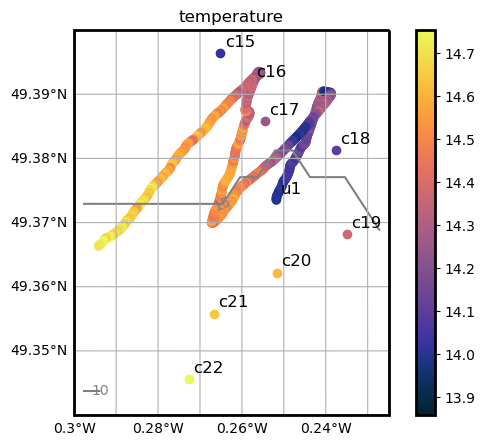

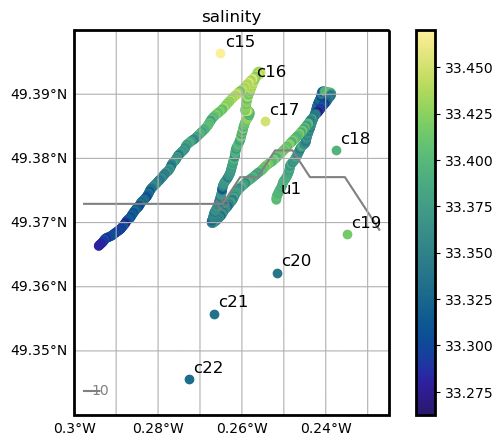

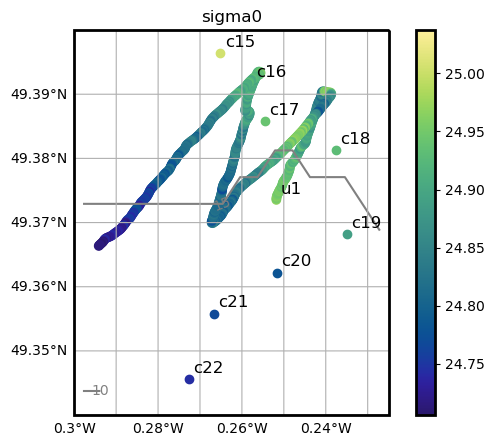

In [19]:
cbar = scatter("temperature", cmap=cm.thermal) # vmin=13.8, vmax=14.1
cbar = scatter("salinity", cmap=cm.haline)
cbar = scatter("sigma0", cmap=cm.haline)
#cbar = scatter("Chl_ugL", cmap=cm.algae) # , vmax=5

### T/S plots

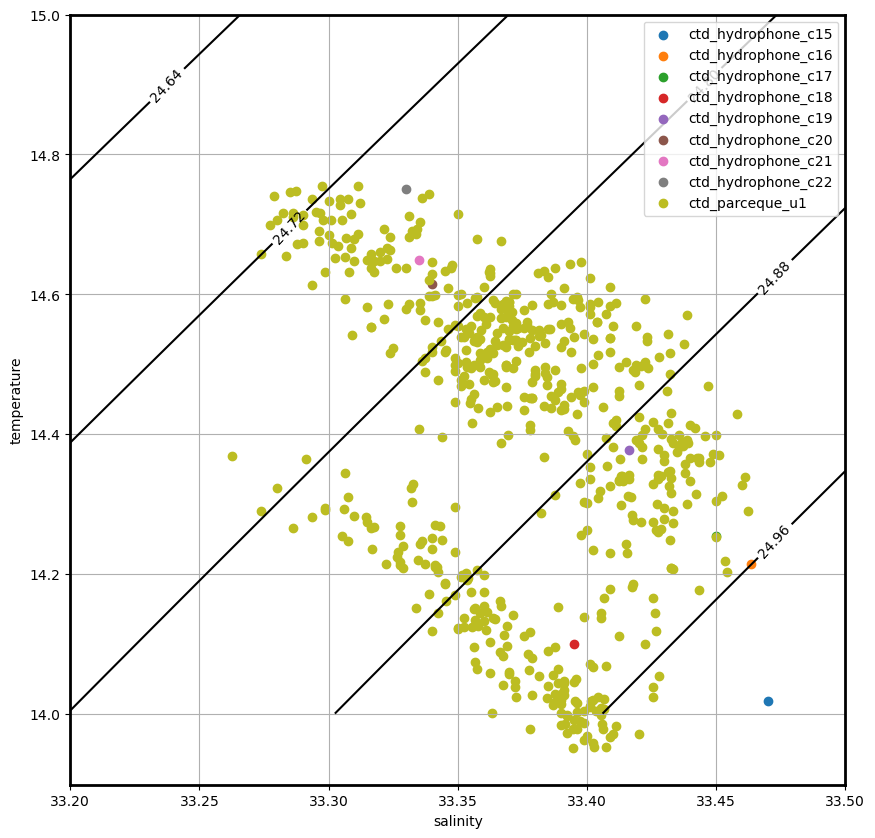

In [20]:
if case==0:
    # taos0_drifters1, day0
    slim, tlim = (32.4, 33.5), (13.5, 15.2) # drifters0 - day 0
elif case==1:
    # taos0_drifters1, day1
    slim, tlim = (33.2, 33.5), (14.0, 15.) # drifters0 - day 1
figsize=(10,10)

D = {}
for u, c in ctd.items():
    for d, _df in c.items():
        if in_tbounds(_df):
            if d[0]=="c":
                _df = _df.bfill().iloc[0]            
            D[u+"_"+d] = _df

fig, ax = pin.seawater.plot_ts(slim, tlim, figsize=figsize)
colors = pin.get_cmap_colors(len(D))
for d, c in zip(D, colors):
    _df = D[d]
    ax.scatter(_df.salinity, _df.temperature, label=d) #, c=c
ax.legend()

### concatenate data back and show histograms

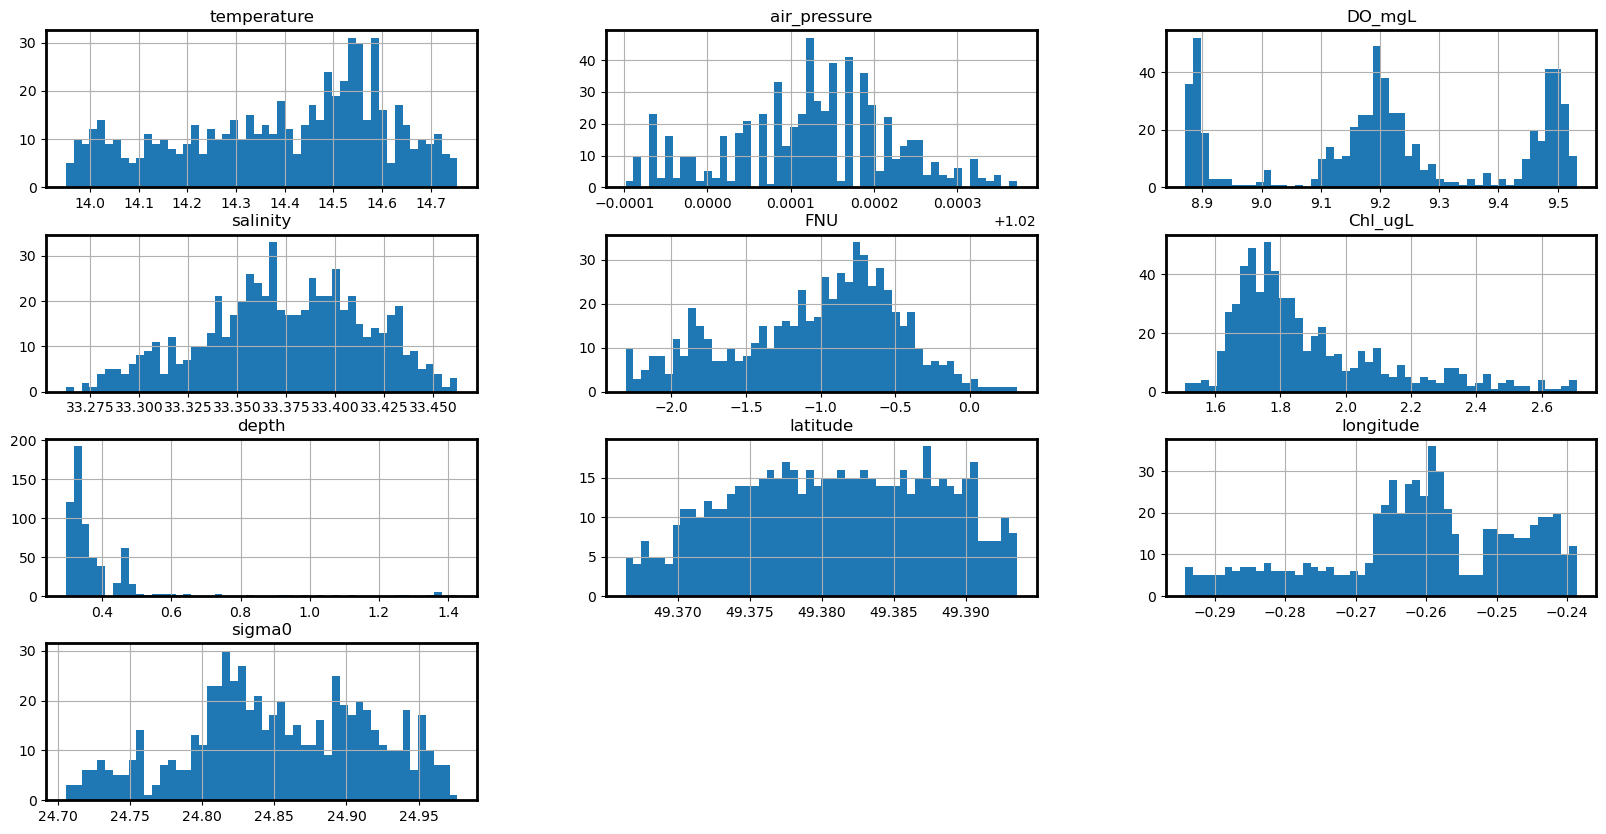

In [22]:
col_drop = ["time", "SA", "CT", "conductivity", "x", "y", "velocity_east", "velocity_north", "velocity", "pressure", "DO_p", "Chl_RFU"]
df = pd.concat([df for d, df in D.items()], axis=0)
df.drop(columns=col_drop, errors='ignore').hist(bins=50, figsize=(20,10));

### CTD cast

In [23]:
figsize=(15,5)

ncasts=0
for u, c in ctd.items():
    for d, _df in c.items():
        if in_tbounds(_df):
            if d[0]=="c":
                ncasts+=1

def plot_profiles(v, offset, units="", ax=None, legend=True):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=figsize)

    colors = pin.get_cmap_colors(ncasts)

    i=0
    for u, c in ctd.items():
        for d, df in c.items():
            if d[0]!="c" or not in_tbounds(df) or v not in df.columns:
                continue
            off = offset*i
            ax.plot(df[v]+off, df.index, color=colors[i], lw=3, label=d) #u+"_"+d
            i+=1

    ax.grid()
    ax.set_title(v)
    ax.set_ylabel("z [m]")
    ax.set_xlabel(units)
    if legend:
        ax.legend(prop={'size': 7}, ncol=2)

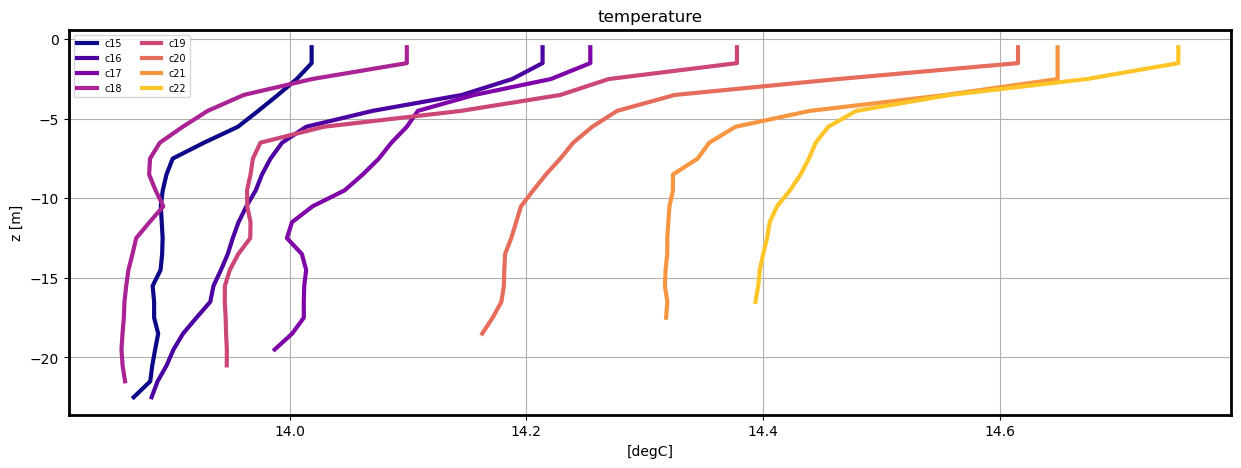

In [24]:
plot_profiles("temperature", 0., units="[degC]")

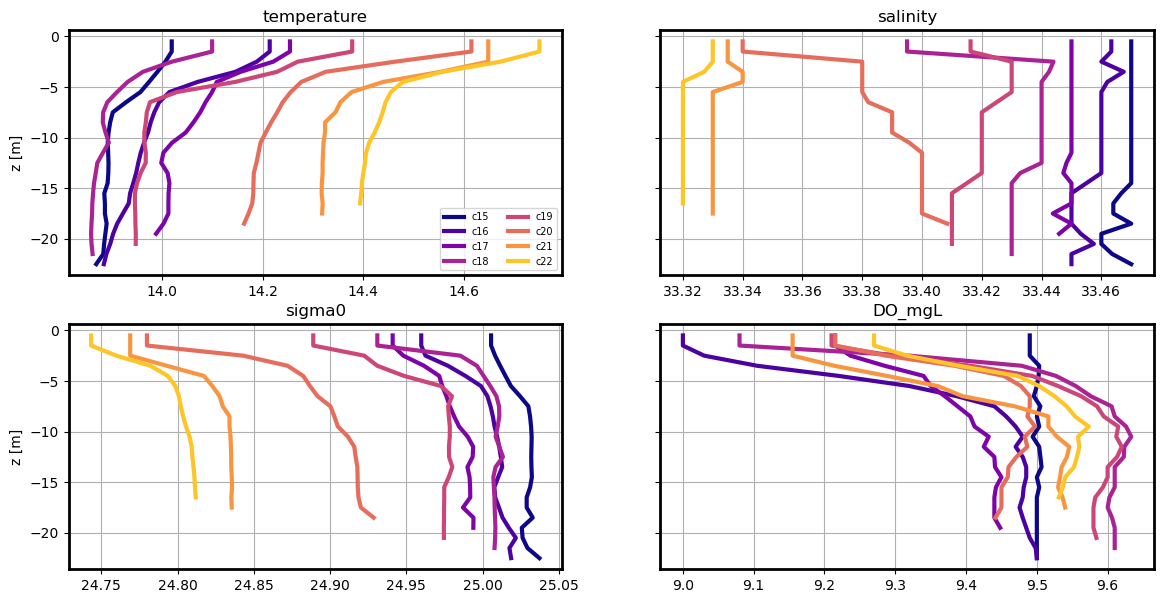

In [25]:
#V = ["temperature", "salinity", "sigma0", "DO_p", "DO_mgL", "FNU", "Chl_RFU",  "Chl_ugL"]
#V = ["temperature", "salinity", "sigma0", "DO_mgL", "FNU",  "Chl_ugL"]
V = ["temperature", "salinity", "sigma0", "DO_mgL"]


ncols = 2
nrows = int(np.ceil(len(V)/ncols))

fig, axes = plt.subplots(nrows, ncols, 
                         figsize=(ncols*7, nrows*3.5),
                         #gridspec_kw=dict(hspace=0.1),
                        )

legend=True
i=0
for v, ax in zip(V, axes.flatten()[:len(V)]):
    plot_profiles(v, 0., units="", ax=ax, legend=legend)
    legend=False
    if i%ncols!=0:
        ax.set_ylabel("")
        ax.set_yticklabels("")
    i+=1

while i<nrows*ncols:
    axes.flatten()[i].axis('off')
    i+=1
    

### Merge all data

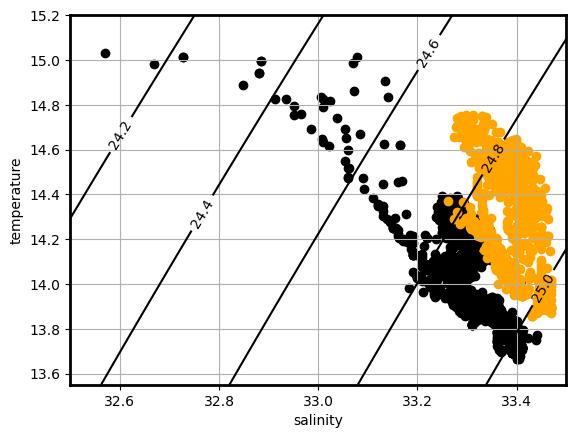

In [27]:
slim, tlim = (32.5, 33.5), (13.55, 15.2)

c0, c1 = "k", "orange"
colors = {**{"u0": c0, "u1": c1}, 
          **{f"c{i}": c0 for i in range(15)},
          **{f"c{i}": c1 for i in range(15,23)},
         }

fig, ax = pin.seawater.plot_ts(slim, tlim)
for s in ctd:
    for d, df in ctd[s].items():
        ax.scatter(df.salinity, df.temperature, label=d, color=colors[d])
#ax.legend()